# Analyzing Pharaglow

### Importing packages

In [1]:
import pandas as pd
import os
import numpy as np
import sympy as sy
import matplotlib.pylab as plt
import skimage
from skimage.util import img_as_float
from skimage.filters import threshold_li
from scipy import ndimage
from skimage.morphology import remove_small_objects
from skimage.exposure import histogram

### Defining function to prepare binary of lawn image

In [2]:
def prepLawn(filename):
    # outlining lawn and turning into binary - thresholding with li (CHANGE NAME)
    image = img_as_float(skimage.io.imread(filename)).astype(np.float64)
    thresh = threshold_li(image)
    binary = image > thresh
    # troubleshooting images with noise around the lawn (optional)
    binary = remove_small_objects(binary, min_size = 5000, connectivity = 2) #change min_size 
    # filling small holes in the lawn
    binary = ndimage.binary_fill_holes(binary).astype(int)
    return binary

### Directing path options and video fps (CHANGE NAMES OR YOUR FILES ARE OVERWRITTEN)

In [3]:
# CHANGE NAME TO FOLDER OF INTEREST
pathname = '/media/scholz_la/hd2/Nicolina/Nicolina/Updated_pharaglow/1x_results/'
outfile = "/media/scholz_la/hd2/Nicolina/Nicolina/Saved_cutVelocities/combined_cutVelocities.csv"

# IS THERE A LAWN?
lawn = 'Yes' #or 'No'
print('Is there a lawn?', lawn)

# FPS
frames = 30
print('fps:', frames)

# CHANGE FIGURE NAMES
all_velocities = "/home/nzjacic/Desktop/Rough_figures/combined_test/combined_all_velocities.pdf"
averaged_velocities = "/home/nzjacic/Desktop/Rough_figures/combined_test/combined_averaged_velocities.pdf"
entry_trajectory = "/home/nzjacic/Desktop/Rough_figures/combined_test/combined_entries_trajectories.pdf"

Is there a lawn? Yes
fps: 30


### Making a dictionary of lawn images based on experiment ID (NZxxxx)

In [4]:
lawnImages = {}
if lawn=='Yes':
    for filename in os.listdir(pathname):
        if filename.endswith(".json"):
            # checking file has been imported
            print(filename)
            # get lawn picture
            lawnfile = filename.split('_')[1]
            if lawnfile not in lawnImages.keys():
                lawnpath = '/media/scholz_la/hd2/Nicolina/Nicolina/Lawns'
                lawnImages[lawnfile] = prepLawn(os.path.join(lawnpath, lawnfile+'_lawn.tiff'))

20200109_NZ0014_MKS_trajectories_4.json
20200109_NZ0014_MKS_trajectories_0.json
20200109_NZ0014_MKS_trajectories_1.json
20200109_NZ0014_MKS_trajectories_10.json
20200109_NZ0014_MKS_trajectories_102.json
20200109_NZ0014_MKS_trajectories_11.json
20200109_NZ0014_MKS_trajectories_114.json
20200109_NZ0014_MKS_trajectories_115.json
20200109_NZ0014_MKS_trajectories_14.json
20200109_NZ0014_MKS_trajectories_19.json
20200109_NZ0014_MKS_trajectories_20.json
20200109_NZ0014_MKS_trajectories_28.json
20200109_NZ0014_MKS_trajectories_29.json
20200109_NZ0014_MKS_trajectories_32.json
20200109_NZ0014_MKS_trajectories_35.json
20200109_NZ0014_MKS_trajectories_36.json
20200109_NZ0014_MKS_trajectories_5.json
20200109_NZ0014_MKS_trajectories_54.json
20200109_NZ0014_MKS_trajectories_55.json
20200109_NZ0014_MKS_trajectories_64.json
20200109_NZ0014_MKS_trajectories_77.json
20200109_NZ0014_MKS_trajectories_78.json
20200109_NZ0014_MKS_trajectories_8.json
20200109_NZ0014_MKS_trajectories_97.json
20200109_NZ0014_MK

### Importing and filtering pharaglow data for "true" trajectories and lawn entries

In [5]:
%%time
# lists
insides = []
velocities = []
t0s = []
xvalues = []
yvalues = []
expIds = []
# loop for importing and saving information from a single results folder into lists
for filename in os.listdir(pathname):
    if filename.endswith(".json"):
        # checking file has been imported
        print(filename)
        # getting python to read .json files
        data = pd.read_json(os.path.join(pathname, filename), orient='split', numpy=True)
        # data extraction if there is a lawn
        if lawn == 'Yes':
            # extracting useful variables
            x = data['x'].values
            y = data['y'].values
            t = data['frame'].values
            z = data['inside'].values
            # filter worms out that are mostly in the lawn at all times
            print("mean(z):", np.mean(z))
            if np.mean(z)<0.1 and np.mean(z)>0.9:
                continue
            # find first point of entry for all worms where t0=/=0 (i.e. where worm is already inside the lawn at 
            # the beginning of the trajectory)
            try:
                # t0 = first point where the worm is inside the lawn
                t0 = np.where(z==1)[0][0]
                print("t0:", t0)
                if t0==0:
                    continue
                t0s.append(t0)
                insides.append(z)
                xvalues.append(x)
                yvalues.append(y)
                expIds.append(filename.split('_')[1])
            except IndexError:
                continue
            print("t0s:", t0s)
            #correcting units from frames to seconds
            t = t/frames
            dt = np.diff(t)
            # calculate velocities
            velocity = np.sqrt(np.diff(x)**2+np.diff(y)**2)/dt
            # convert velocity units to microns/s
            velocity *= (2.349)#/33*1000
            # save the velocity results in a list
            velocities.append([t, velocity])
        # data extraction if it's a no lawn control
        else:
            # velocity calculations
            x = data['x'].values
            y = data['y'].values
            t = data['frame'].values
            #correcting units from frames to seconds
            t = t/frames
            # calculate velocities
            dt = np.diff(t)
            velocity = np.sqrt(np.diff(x)**2+np.diff(y)**2)/dt
            # convert velocity units to microns/s
            velocity *= (2.349)#/33*1000
            # save the results in a list
            velocities.append([t, velocity])

20200109_NZ0014_MKS_trajectories_4.json
mean(z): 0.8990898298377523
t0: 255
t0s: [255]
20200109_NZ0014_MKS_trajectories_0.json
mean(z): 0.7669076988515525
t0: 844
t0s: [255, 844]
20200109_NZ0014_MKS_trajectories_1.json
mean(z): 0.7453300733496333
t0: 1174
t0s: [255, 844, 1174]
20200109_NZ0014_MKS_trajectories_10.json
mean(z): 0.5855855855855856
t0: 552
t0s: [255, 844, 1174, 552]
20200109_NZ0014_MKS_trajectories_102.json
mean(z): 0.7451213707758211
t0: 0
20200109_NZ0014_MKS_trajectories_11.json
mean(z): 0.44851063829787235
t0: 648
t0s: [255, 844, 1174, 552, 648]
20200109_NZ0014_MKS_trajectories_114.json
mean(z): 1.0
t0: 0
20200109_NZ0014_MKS_trajectories_115.json
mean(z): 1.0
t0: 0
20200109_NZ0014_MKS_trajectories_14.json
mean(z): 0.883111954459203
t0: 0
20200109_NZ0014_MKS_trajectories_19.json
mean(z): 0.8827900287631831
t0: 0
20200109_NZ0014_MKS_trajectories_20.json
mean(z): 0.9837008628954937
t0: 0
20200109_NZ0014_MKS_trajectories_28.json
mean(z): 1.0
t0: 0
20200109_NZ0014_MKS_trajec

### Plot of velocities from all trajectories that meet the criteria above

0
1
2
3
4
5
6
7
8
9
10
11
12


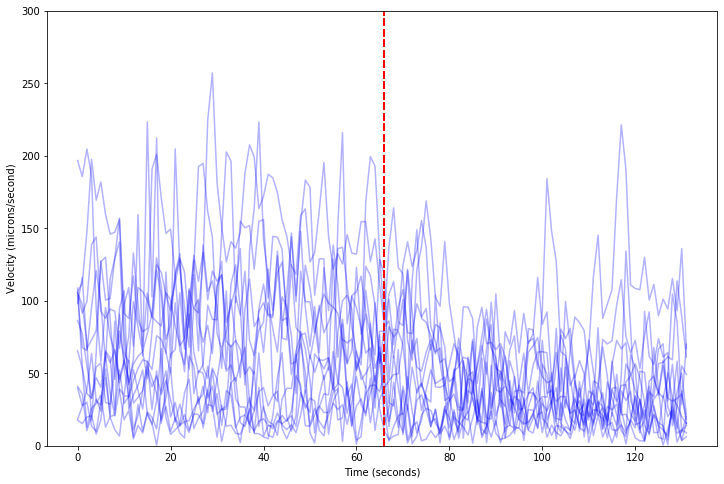

In [6]:
# cut is the number of seconds on either side of the point of lawn entry for each trajectory
cut = 66

# making figure a bigger size
plt.figure(figsize=(12,8))

# listing only certain "cut" velocities
cutVelocity = []

# looping through the velocities
for i, (t,velocity) in enumerate(velocities):
    print(i)
    # data extraction if there is a lawn
    if lawn == 'Yes':
        t0 = t0s[i]
        # trajectories shorter than twice the cut value cannot be cut so are excluded
        if t0 < 2*cut:
            continue
        #plotting data upstream and downstream of lawn entry for each trajectory
        plt.plot(np.arange(2*cut), velocity[t0-cut:t0+cut], color = 'b', alpha=0.3)
        plt.ylabel('Velocity (microns/second)')
        plt.xlabel('Time (seconds)')
        # making sure all graphs are on the same y-scale to be more comparable
        plt.ylim(top = 300.0, bottom = 0.0)
        plt.axvline(x = cut, color = 'red', dashes = (5, 2))
        # cropping data sets only to value of "cut" above and below point of lawn entry
        cutVelocity.append(velocity[t0-cut:t0+cut])
        # save plot as .pdf (CHANGE NAME)
        plt.savefig(all_velocities)
    # data extraction if it's a no lawn control
    else:
        # plotting so that trajectories all begin when t = 0s on graph
        plt.plot(t[:-1], velocity, color = 'b', alpha = 0.3)
        plt.ylabel('Velocity (microns/second)')
        plt.xlabel('Time (seconds)')
        # making sure all graphs are on the same y-scale to be more comparable
        plt.ylim(top = 300.0, bottom = 0.0)
        # make the trajectories the same length - look at the figure and change "cut" value based on data
        vn = np.pad(velocity[:cut], [0, cut-len(velocity[:cut])], mode='constant', constant_values=np.nan)
        cutVelocity.append(vn)
        # save plot as .pdf (CHANGE NAME)
        plt.savefig(all_velocities)

### Saving cutVelocity data

In [7]:
# making cutVelocities into a data frame
features = cutVelocity
features = pd.DataFrame(features)
print("Checking features:", features)

#checking data frame
features.info(memory_usage='deep')

#saving as .csv file
features.to_csv(outfile)

Checking features:            0           1           2           3           4           5    \
0   106.347365  112.092241  147.841553  197.635406  169.408397  182.031037   
1   105.563654   91.519266   99.595434  138.828020  144.051085   92.745029   
2    86.476024   77.293558   54.991893   32.618074   54.309081   57.131498   
3   196.778185  185.677138  204.711155  186.010158   93.687223   58.171494   
4    65.492370   53.733240   36.061499   32.816488   47.122352   40.447291   
5    17.638142   15.296292   19.873143   20.668021    8.035670   17.893313   
6    98.251059  116.203739   66.992857   73.068008   79.423357  127.439151   
7    40.969947   35.591257   10.499178   20.763628   32.179086   23.895037   
8   105.198914   97.559775   70.777825   17.382534   64.488585  126.955481   
9    18.412654   27.101940   39.075435   63.683685   30.851854   28.118730   
10   39.783688   27.697732   30.061147   13.620615    9.889519   30.549450   
11  108.788856   53.970218   12.946846   25.8

### Loading cutVelocity data

In [8]:
#cutVelocity = pd.read_csv(outfile)

### Averaged velocities plot with standard deviation

(13, 132)


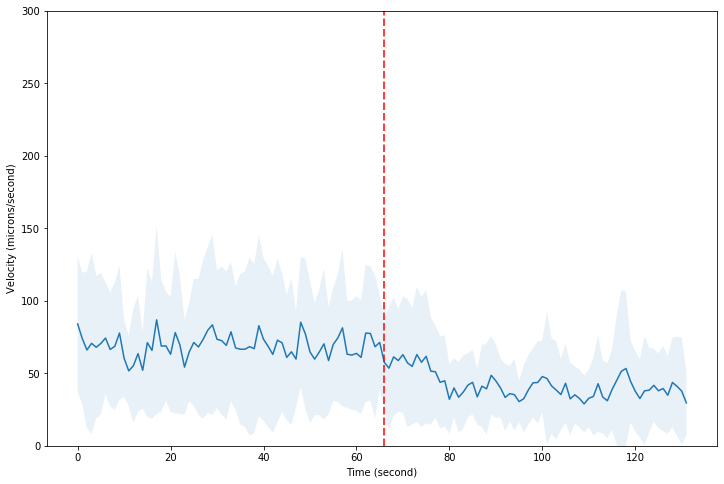

In [9]:
# increasing figure size
plt.figure(figsize=(12,8))

# checking values are the correct shape for graphing
print(np.array(cutVelocity).shape)

# averaging velocity values and calculating STDs before turning them into arrays for plotting
m, s = np.mean(np.array(cutVelocity), axis =0), np.std(np.array(cutVelocity), axis =0)

# plotting average velocities with STD
# data extraction if there is a lawn
if lawn == 'Yes':
    plt.plot(m)
    plt.fill_between(np.arange(len(m)), m-s, m+s, alpha = 0.1, zorder = -5)
    plt.ylim(top = 300.0, bottom = 0.0)
    plt.ylabel('Velocity (microns/second)')
    plt.xlabel('Time (second)')
    plt.axvline(x = cut, color = 'red', dashes = (5, 2))
    # save plot as .pdf (CHANGE NAME)
    plt.savefig(averaged_velocities)
# data extraction if it's a no lawn control
else:
    # plotting average velocities and correcting m units to seconds instead of frames
    plt.plot(np.linspace(0, cut/frames, len(m)), m)
    plt.ylabel('Velocity (microns/second)')
    plt.xlabel('Time (second)')
    # making sure all graphs are on the same y-scale to be more comparable
    plt.ylim(top = 300.0, bottom = 0.0)
    # adding STDs and correcting units to seconds
    plt.fill_between(np.linspace(0, cut/frames, len(m)), m-s, m+s, alpha = 0.1, zorder = -5)
    # save plot as .pdf (CHANGE NAME)
    plt.savefig(averaged_velocities)

### Visualizing all trajectories and lawn entry points (WITH lawn only)

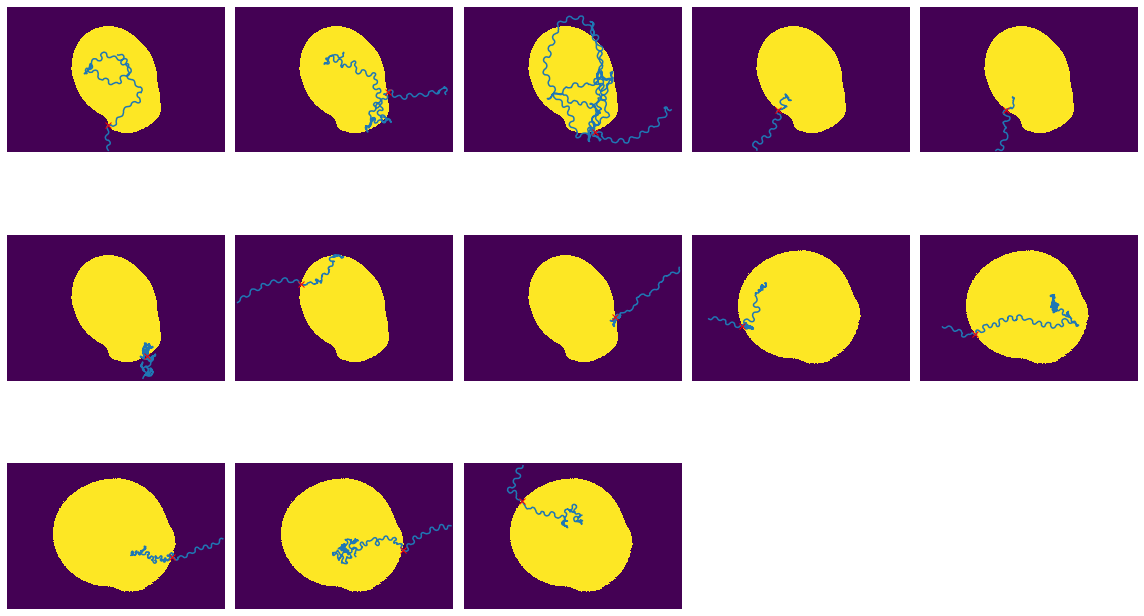

In [10]:
# plotting
if lawn == 'Yes':
    # increasing figure size
    plt.figure(figsize=(16,16))
    # making data values the same size 
    Ndatasets = len(xvalues)
    for index in range(Ndatasets):
        # change first two parameters to make a square figure depending on the number of trajectories
        plt.subplot(5,5,index+1)
        ## setting binary of lawn as the background
        expId = expIds[index]
        plt.imshow(lawnImages[expId])
        # making all variables the same length
        x, y = xvalues[index],yvalues[index]
        t0 = t0s[index]
        plt.plot(x, y)
        # create a red X at the x and y value where the worm enters (i.e. t0)
        plt.plot(x[t0],y[t0], 'rx')
        # no plot axes necessary
        plt.axis('off')
    #neater layout
    plt.tight_layout()
    # save plot as .pdf (CHANGE NAME)
    plt.savefig(entry_trajectory)